<a href="https://colab.research.google.com/github/naznmr/DataMining/blob/main/datamining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# بارگذاری داده‌ها

features_df = pd.read_csv(
    "/content/drive/MyDrive/datamining/Current_score.csv",
    encoding = "cp1252",
    on_bad_lines = "skip", # خطا در فایل csv
    engine = "python" # C
)

target_df = pd.read_csv(
    "/content/drive/MyDrive/datamining/Current_SCORE_CHURN.csv",
    encoding = "cp1252",
    on_bad_lines = "skip",
    engine = "python"
)

In [ ]:
# اطمینان از اینکه هدف فقط یه سری است

if target_df.shape[1] == 1:
    target_series = target_df.iloc[:, 0]
else:
    target_series = target_df.squeeze()

target_series = target_df["churn"]

print("توزیع هدف :")
print(target_series.value_counts(normalize = True))

print("نام ستون‌های ویژگی‌ها : ")
print(features_df.columns.tolist())

توزیع هدف :
churn
0.0    0.98199
1.0    0.01801
Name: proportion, dtype: float64
نام ستون‌های ویژگی‌ها : 
['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'rev_Range', 'mou_Range', 'totmrc_Range', 'da_Range', 'ovrmou_Range', 'ovrrev_Range', 'vceovr_Range', 'datovr_Range', 'roam_Range', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Me

In [ ]:
# ادغام داده‌ها

full_data = pd.concat([features_df, target_series], axis = 1)

In [ ]:
# تبدیل مقادیر رشته‌ای "NaN" به np.nan

full_data.replace("NaN", np.nan, inplace = True)

In [ ]:
# تعریف لیست مقدارهای ناپدید شده غیر استاندارد

missing_tokens = ["?", "NA", "N/A", "NaN", "null", "NULL", "999", "9999", "unknown", "-1", " ", ""]

In [ ]:
# جایگزینی مقدارهای ناپدید شده سفارشی با np.nan

full_data = full_data.replace(missing_tokens, np.nan)

In [ ]:
# محاسبه درصد مقادیر گمشده در هر ستون

missing_pct = full_data.isnull().mean() * 100

print("ستون‌های دارای missing value به ترتیب درصد : ")
print(missing_pct[missing_pct > 0].sort_values(ascending = False))

ستون‌های دارای missing value به ترتیب درصد : 
mailflag       98.540132
solflag        97.828714
wrkwoman       87.184735
educ1          86.054263
pcowner        81.370600
                 ...    
avg6qty         0.265076
REF_QTY         0.265076
retdays         0.265076
eqpdays         0.265076
Customer_ID     0.265076
Length: 172, dtype: float64


In [ ]:
# حذف ستون‌هایی که بیش از 30% missing دارند

drop_cols = missing_pct[missing_pct > 30].index.tolist()
full_data.drop(columns = drop_cols, inplace = True)
print(f"ستون‌های حذف شده به دلیل missing value بالا : {drop_cols}")

ستون‌های حذف شده به دلیل missing value بالا : ['div_type', 'occu1', 'ownrent', 'dwlltype', 'mailordr', 'wrkwoman', 'mailresp', 'children', 'numbcars', 'cartype', 'HHstatin', 'mailflag', 'solflag', 'dwllsize', 'educ1', 'proptype', 'pcowner']


In [ ]:
# برخی ویژگی‌ها که ممکنه صفرها معنی missing داشته باشند

zero_as_missing_cols = [
    "hnd_price", "pre_hnd_price", "income", "age1", "age2",
    "avg6mou", "avg6qty", "avg6rev", "avg3mou", "avg3qty",
    "avg3rev", "avgrev", "avgmou", "avgqty", "models",
    "phones", "totcalls", "totmou", "totrev"
]

In [ ]:
# تبدیل این ستون‌ها به عددی (اگر رشته بودند)

for col in zero_as_missing_cols:
    if col in full_data.columns:
        full_data[col] = pd.to_numeric(full_data[col], errors = "coerce")

In [ ]:
# حذف یا جایگزینی صفرها بسته به درصد آن‌ها

drop_due_to_zero = []
threshold_zero = 0.3  # 30 درصد

for col in zero_as_missing_cols:
    if col in full_data.columns:
        zero_ratio = (full_data[col] == 0).mean()
        if zero_ratio > threshold_zero:
            print(f"حذف ستون {col} به دلیل درصد زیاد صفر ({zero_ratio:.2%})")
            full_data.drop(columns=col, inplace=True)
            drop_due_to_zero.append(col)
        else:
            median_nonzero = full_data.loc[full_data[col] != 0, col].median()
            full_data.loc[full_data[col] == 0, col] = median_nonzero
            print(f"جایگزینی صفرها در ستون {col} با میانه {median_nonzero}")

print("ستون‌های حذف شده به خاطر صفرهای زیاد:", drop_due_to_zero)
print("شکل نهایی داده‌ها :", full_data.shape)
print("ستون‌های باقی‌مانده :")
print(full_data.columns.tolist())

جایگزینی صفرها در ستون hnd_price با میانه 129.99
جایگزینی صفرها در ستون pre_hnd_price با میانه 59.99
جایگزینی صفرها در ستون income با میانه 6.0
جایگزینی صفرها در ستون age1 با میانه 44.0
حذف ستون age2 به دلیل درصد زیاد صفر (50.88%)
جایگزینی صفرها در ستون avg6mou با میانه 387.0
جایگزینی صفرها در ستون avg6qty با میانه 133.0
جایگزینی صفرها در ستون avg6rev با میانه 50.0
جایگزینی صفرها در ستون avg3mou با میانه 390.0
جایگزینی صفرها در ستون avg3qty با میانه 134.0
جایگزینی صفرها در ستون avg3rev با میانه 50.0
جایگزینی صفرها در ستون avgrev با میانه 50.31
جایگزینی صفرها در ستون avgmou با میانه 371.135
جایگزینی صفرها در ستون avgqty با میانه 129.52
جایگزینی صفرها در ستون models با میانه 1.0
جایگزینی صفرها در ستون phones با میانه 1.0
جایگزینی صفرها در ستون totcalls با میانه 1789.0
جایگزینی صفرها در ستون totmou با میانه 5158.0
جایگزینی صفرها در ستون totrev با میانه 788.88
ستون‌های حذف شده به خاطر صفرهای زیاد: ['age2']
شکل نهایی داده‌ها : (51306, 155)
ستون‌های باقی‌مانده :
['rev_Mean', 'mou_Mean', 'tot

In [ ]:
# پر کردن مقادیر گمشده در ستون‌های عددی با میانه

# Select only the numeric columns
numeric_data = full_data.select_dtypes(include = np.number)

# Find the columns within the numeric data that have missing values
num_cols_with_missing = numeric_data.columns[numeric_data.isnull().any()]

for col in num_cols_with_missing:
    median_val = full_data[col].median() # Use the original full_data for median calculation
    full_data[col].fillna(median_val, inplace = True)
    print(f"پر کردن missingهای ستون عددی {col} با مقدار میانه {median_val}")

پر کردن missingهای ستون عددی drop_vce_Mean با مقدار میانه 3.0
پر کردن missingهای ستون عددی drop_dat_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی blck_vce_Mean با مقدار میانه 1.0
پر کردن missingهای ستون عددی blck_dat_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی unan_vce_Mean با مقدار میانه 17.0
پر کردن missingهای ستون عددی unan_dat_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی plcd_vce_Mean با مقدار میانه 107.0
پر کردن missingهای ستون عددی plcd_dat_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی recv_vce_Mean با مقدار میانه 29.0
پر کردن missingهای ستون عددی recv_sms_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی comp_vce_Mean با مقدار میانه 80.667
پر کردن missingهای ستون عددی comp_dat_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی custcare_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی ccrndmou_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی cc_mou_Mean با مقدار میانه 0.0
پر کردن missingهای ستون عددی inonemin_Mean با مقدار میانه 13.333


<ipython-input-41-85566696c41c>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data[col].fillna(median_val, inplace = True)


In [ ]:
# ستون infobase فقط 'M' و NaN داره، حذفش می‌کنیم

if "infobase" in full_data.columns:
    print(full_data["infobase"].value_counts(dropna = False))
    full_data.drop(columns = ["infobase"], inplace = True)
    print("ستون 'infobase' حذف شد.")

infobase
M      40087
NaN    11065
N        154
Name: count, dtype: int64
ستون 'infobase' حذف شد.


In [ ]:
# پر کردن missingهای چند ستون دسته‌ای (categorical)

categorical_fill_map = {
    "prizm_social_one" : "Missing",
    "hnd_webcap" : "UNKW",
    "ethnic" : "Missing",
    "car_buy" : "UNKNOWN",
    "kid0_2" : "U",
    "kid3_5" : "U",
    "kid6_10" : "U",
    "kid11_15" : "U",
    "kid16_17" : "U",
    "marital" : "U"
}

for cat_col, fill_val in categorical_fill_map.items():
    if cat_col in full_data.columns:
        full_data[cat_col] = full_data[cat_col].fillna(fill_val)

In [ ]:
# تبدیل مقادیر باینری دسته‌ای به عددی

if "car_buy" in full_data.columns:
    full_data["car_buy"] = full_data["car_buy"].map({"New" : 1, "UNKNOWN" : 0})

for kid_col in ["kid0_2", "kid3_5", "kid6_10", "kid11_15", "kid16_17"]:
    if kid_col in full_data.columns:
        full_data[kid_col] = full_data[kid_col].map({"Y" : 1, "U" : 0})

if "creditcd" in full_data.columns:
    full_data["creditcd"] = full_data["creditcd"].fillna("N").map({"Y" : 1, "N" : 0})

In [ ]:
# آماده‌سازی برای مدل

X_data = full_data.drop(columns = ["churn", "Customer_ID"], errors = "ignore")
y_data = full_data["churn"]

print("توزیع کلاس‌ها قبل از نمونه‌گیری :")
print(y_data.value_counts(normalize = True))

توزیع کلاس‌ها قبل از نمونه‌گیری :
churn
0.0    0.98199
1.0    0.01801
Name: proportion, dtype: float64


In [ ]:
# Over-sampling برای رفع imbalance

ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_data, y_data)

print("توزیع کلاس‌ها بعد از Over-sampling:")
print(y_resampled.value_counts(normalize=True))

توزیع کلاس‌ها بعد از Over-sampling:
churn
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [ ]:
X_encoded = X_resampled.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

In [ ]:
# مدل رندوم فارست با cross-validation

# جایگزینی inf با NaN
X_encoded = X_encoded.replace([np.inf, -np.inf], np.nan)

# پر کردن NaN با میانه ستون‌ها
na_cols = X_encoded.columns[X_encoded.isnull().any()]
for col in na_cols:
    X_encoded[col].fillna(X_encoded[col].median(), inplace=True)

# تبدیل dtype برای کاهش مصرف حافظه
for col in X_encoded.select_dtypes(include=['float64']).columns:
    X_encoded[col] = X_encoded[col].astype('float32')

for col in X_encoded.select_dtypes(include=['int64']).columns:
    X_encoded[col] = X_encoded[col].astype('int32')

# نمونه‌گیری ۲۰٪ داده برای اجرای سریع (اختیاری)
sample_frac = 0.2
X_sample = X_encoded.sample(frac=sample_frac, random_state=42)
y_sample = y_resampled.loc[X_sample.index]

# مدل رندوم فارست با تعداد درخت کمتر و استفاده از همه هسته‌های CPU
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



auc_scores = cross_val_score(rf_model, X_encoded, y_resampled, cv=cv, scoring='roc_auc')

print("امتیازهای ROC-AUC در Cross Validation:")
print(auc_scores)
print("میانگین امتیاز ROC-AUC:", auc_scores.mean())

امتیازهای ROC-AUC در Cross Validation:
[0.99999828 0.99999837 0.99999846 0.99999857 0.99999815]
میانگین امتیاز ROC-AUC: 0.9999983680274657


In [ ]:
# Over-sampling برای رفع imbalance

ros = RandomOverSampler(sampling_strategy = "not majority", random_state = 42)
X_resampled, y_resampled = ros.fit_resample(X_data, y_data)

print("توزیع کلاس‌ها بعد از Over-sampling :")
print(y_resampled.value_counts(normalize = True))

توزیع کلاس‌ها بعد از Over-sampling :
churn
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [ ]:
# --------- آموزش مدل و ارزیابی نهایی ---------

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)

rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    random_state=42
)

rf_final.fit(X_train, y_train)

y_pred = rf_final.predict(X_test)
y_prob = rf_final.predict_proba(X_test)[:, 1]

print("Accuracy (train):", rf_final.score(X_train, y_train))
print("Accuracy (test):", accuracy_score(y_test, y_pred))
print("F1 score (train):", f1_score(y_train, rf_final.predict(X_train)))
print("F1 score (test):", f1_score(y_test, y_pred))
print("ROC AUC (test):", roc_auc_score(y_test, y_prob))

print("\nگزارش طبقه‌بندی (test):")
print(classification_report(y_test, y_pred))

Accuracy (train): 0.8818725720928914
Accuracy (test): 0.8757525636784651
F1 score (train): 0.8918568128131247
F1 score (test): 0.8864296081277213
ROC AUC (test): 0.966515969911569

گزارش طبقه‌بندی (test):
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     15115
         1.0       0.82      0.97      0.89     15115

    accuracy                           0.88     30230
   macro avg       0.89      0.88      0.87     30230
weighted avg       0.89      0.88      0.87     30230



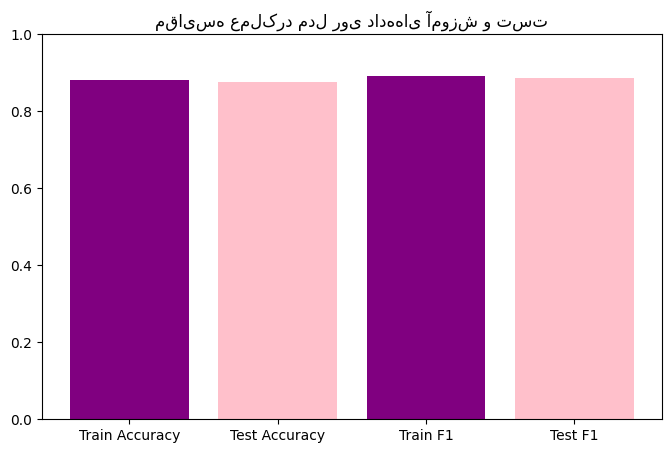

In [ ]:
# نمایش گرافیکی

plt.figure(figsize=(8,5))
plt.bar(['Train Accuracy', 'Test Accuracy', 'Train F1', 'Test F1'],
        [rf_final.score(X_train, y_train), accuracy_score(y_test, y_pred),
         f1_score(y_train, rf_final.predict(X_train)), f1_score(y_test, y_pred)],
        color=['purple', 'pink', 'purple', 'pink'])
plt.ylim(0, 1)
plt.title('مقایسه عملکرد مدل روی داده‌های آموزش و تست')
plt.show()